# Torch grid_sample
We can use grid_sample + affine_grid to apply an affine transformation to the patch of the map. But both grid_sample and affine_grid work in weird camera coordinates, normalized to [-1, 1]. In this example I only need the rotation matrix part of affine transformation.

In 2D ij -> camera coords, ij -> ji, j gets flipped.

In 3D ijk -> camera coords, ijk -> kji; j gets flipped.

I used this solution for the normalized transormation matrix input... https://discuss.pytorch.org/t/how-to-convert-an-affine-transform-matrix-into-theta-to-use-torch-nn-functional-affine-grid/24315/2.

And this link is also useful https://www.brainvoyager.com/bv/doc/UsersGuide/CoordsAndTransforms/SpatialTransformationMatrices.html.

In [747]:
from torch.nn.functional import grid_sample, affine_grid
import torch
import numpy as np
from matplotlib import pyplot as plt

In [801]:
# For 3D case

import plotly.graph_objects as go
from scipy.spatial.transform import Rotation

def get_random_rot(as_rot=True):
    # From Choosing a Point from the Surface of a Sphere by George Marsaglia:
    x, y, z, u, v, w, s = 20, 20, 20, 20, 20, 20, 20
    while z > 1:
        x = np.random.uniform(-1, 1)
        y = np.random.uniform(-1, 1)
        z = x * x + y * y
    while w > 1:
        u = np.random.uniform(-1, 1)
        v = np.random.uniform(-1, 1)
        w = u * u + v * v

    s = np.sqrt((1 - z) / w);
    qt = Rotation.from_quat(np.array([x, y, s * u, s * v]))
    if as_rot:
        return qt
    return qt.as_matrix()


### Simple 2D case to trace individual points, no rotations

In [802]:
# our grid in ij
my_grid = np.array(np.meshgrid(np.arange(-2., 1.1, 1.), np.arange(-2., 2.1, 1.), indexing='ij')).transpose([1, 2, 0])
# voxel size
vs = 1.
nx, ny = my_grid.shape[0], my_grid.shape[1]
nxy = np.array([nx, ny])
# our data in ij
my_data = np.array([[0, 4, 8, 12, 16], 
                    [1, 5, 9, 13, 17], 
                    [2, 6, 10, 14, 18], 
                    [3, 7, 11, 15, 19]])
my_data_t = torch.tensor(my_data, dtype=torch.float32)

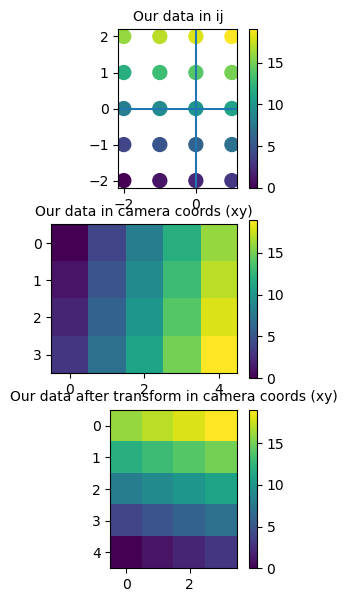

In [803]:
fig, axs = plt.subplots(3)
plt0 = axs[0].scatter(my_grid.reshape([nx * ny, 2])[:, 0], 
            my_grid.reshape([nx * ny, 2])[:, 1], 
            c=my_data.flatten(), cmap='viridis', s=100., vmin=np.amin(my_data), vmax=np.amax(my_data)
           )
fig.colorbar(plt0)
axs[0].set_title('Our data in ij', fontsize=10)
axs[0].axvline(0., c='tab:blue')
axs[0].axhline(0., c='tab:blue')
axs[0].set_aspect('equal')


im1 = axs[1].imshow(my_data, cmap='viridis', vmin=np.amin(my_data), vmax=np.amax(my_data)
           )
fig.colorbar(im1)
axs[1].set_title('Our data in camera coords (xy)', fontsize=10)


im2 = axs[2].imshow(np.flip(my_data.transpose(1, 0), 0), cmap='viridis', vmin=np.amin(my_data), vmax=np.amax(my_data)
           )
fig.colorbar(im2)
axs[2].set_title('Our data after transform in camera coords (xy)', fontsize=10)

fig.set_size_inches((3, 7))

In [848]:
def interpolate_ij_xy_2d(my_grid, my_data_t, 
                         nx, ny, 
                         compute_error=False, 
                         r=np.array([[1., 0.], [0., 1.]]),
                         tv=None, nx_patch=None, ny_patch=None):
    origin = np.amin(my_grid.reshape(nx * ny, 2), axis=(0))

    t = torch.tensor([
        [1., 0., 0.],
        [0., 1., 0.]])
    
    # patch center in number of voxels from the corner; yx instead of ij
    tc1 = torch.tensor([np.ceil(ny - 1.)/2., np.ceil(nx - 1.)/2.]) if tv is None else torch.tensor([tv[1], tv[0]])
    nx0 = (ny-1)/2
    ny0 = (nx-1)/2
    nxy0 = np.array([nx0, ny0])
    # patch size in number of voxels; yx instead of ij
    nx4, ny4 = ny if ny_patch is None else ny_patch, nx if nx_patch is None else nx_patch        
    nxy4 = np.array([nx4, ny4])
    sz_ = [1, 1, nx4, ny4]  # patch size in number of voxels; yx instead of ij
    sz = torch.Size(sz_)
    sz_t = torch.Size([sz_[0], sz_[1], sz_[3], sz_[2]])
    
    h = ny4
    w = nx4
    
    t[0,0] = r[0][0]
    t[0,1] = r[0][1]*h/w 
    t[1,0] = r[1][0]*w/h
    t[1,1] = r[1][1]
    # theta[0,2] = param[0,2]*2/w + theta[0,0] + theta[0,1] - 1
    # theta[1,2] = param[1,2]*2/h + theta[1,0] + theta[1,1] - 1
    
    
    grd = torch.nn.functional.affine_grid(t.unsqueeze(0), sz_t).permute(0, 2, 1, 3)
    # print(grd.shape, my_grid.shape)
    grd_real_im = ((grd * torch.tensor(sz_[2:]) * 0.5 + tc1) * vs) + origin[::-1]
    grd_relative = (grd_real_im - (origin[::-1] + nxy0 * vs)) / (nxy0 * vs)
    my_data2 = torch.nn.functional.grid_sample(
        my_data_t.unsqueeze(0).unsqueeze(0), 
        grd_relative.to(dtype=torch.float32), mode='bilinear', padding_mode='reflection')
    my_data2_final = my_data2[0][0].transpose(1, 0).numpy()
    grd_real = np.flip(grd_real_im[0].numpy().transpose(1, 0, 2), 2)
    
    if compute_error:
        print('mae', np.mean(np.abs(my_data_t.flatten().numpy() - my_data2[0][0].transpose(1, 0).flatten().numpy())))
        print('mean', np.mean(np.abs(my_data_t.flatten().numpy())))
    return grd_real, my_data2_final, nx4, ny4

mae 0.45
mean 9.5


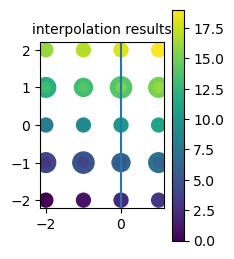

In [805]:
grd_real, my_data2_final, nx4, ny4 = interpolate_ij_xy_2d(my_grid, my_data_t, nx, ny, compute_error=True)

plt.scatter(grd_real.reshape([nx4 * ny4, 2])[:, 0], 
            grd_real.reshape([nx4 * ny4, 2])[:, 1], 
            c=my_data.flatten(), cmap='viridis', 
            s=np.abs(my_data.flatten() - my_data2_final.flatten()) * 200, 
            vmin=np.amin(my_data), vmax=np.amax(my_data)
           )

plt.scatter(my_grid.reshape([nx * ny, 2])[:, 0], 
            my_grid.reshape([nx * ny, 2])[:, 1], 
            c=my_data.flatten(), cmap='viridis', s=100.,
            vmin=np.amin(my_data), vmax=np.amax(my_data)
           )

plt.scatter(grd_real.reshape([nx4 * ny4, 2])[:, 0], 
            grd_real.reshape([nx4 * ny4, 2])[:, 1], 
            c=my_data2_final.flatten(), cmap='viridis',  # my_data_im_back
            s=50., 
            vmin=np.amin(my_data), vmax=np.amax(my_data)
           )
plt.colorbar()
plt.axvline(0., c='tab:blue')
plt.title('interpolation results', fontsize=10)
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches((2, 3))


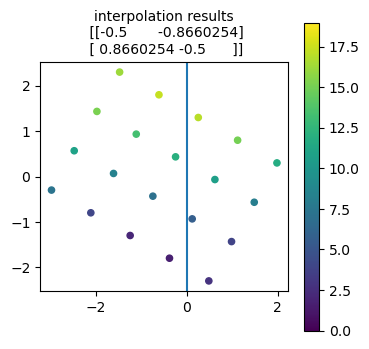

In [808]:
theta_ = np.pi - 60. *  np.pi / 180.  # x and y are swapped
tr = np.array([[np.cos(theta_), -np.sin(theta_)],
               [np.sin(theta_),  np.cos(theta_)]])

grd_real, my_data2_final, nx4, ny4 = interpolate_ij_xy_2d(my_grid, my_data_t, nx, ny,
                                                          r=tr)
plt.figure()
# plt.scatter(my_grid.reshape([nx * ny, 2])[:, 0], 
#             my_grid.reshape([nx * ny, 2])[:, 1], 
#             c=my_data.flatten(), cmap='viridis', s=20.,
#             vmin=np.amin(my_data), vmax=np.amax(my_data)
#            )

plt.scatter(grd_real.reshape([nx4 * ny4, 2])[:, 0], 
            grd_real.reshape([nx4 * ny4, 2])[:, 1], 
            c=my_data2_final.flatten(), cmap='viridis',  # my_data_im_back
            s=20., 
            vmin=np.amin(my_data), vmax=np.amax(my_data)
           )
plt.colorbar()
plt.axvline(0., c='tab:blue')
plt.title(f'interpolation results\n {tr}', fontsize=10)
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches((4, 4))


### 2D, no rotations, more points

In [809]:
crds = np.vstack([np.random.uniform(-5, 5, (100, 2)),
                  np.random.uniform(-6, 6, (100, 2)),]
                )
for i in range(5):
    loc = np.random.choice(range(len(crds)))
    crds = np.append(crds, 
                  np.random.normal(loc=crds[loc], scale=[1., 1.], size=(20, 2)), axis=0)

In [810]:
crd_min = np.min(crds, axis=0)
crd_max = np.max(crds, axis=0)
crd_com = np.mean(crds, axis=0)
crd_padding = np.array([2.5, 2.5])

vs = 0.4
my_grid = np.array(np.meshgrid(np.arange((crd_min - crd_padding)[0], (crd_max + crd_padding)[0], vs),
                               np.arange((crd_min - crd_padding)[1], (crd_max + crd_padding)[1], vs), indexing='ij')).transpose([1, 2, 0])
nx, ny = my_grid.shape[0], my_grid.shape[1]
nxy = np.array([nx, ny])
my_data = np.exp(
    -((my_grid.reshape([nx, ny, 1, my_grid.shape[2]]) - crds.reshape([1, 1, crds.shape[0], crds.shape[1]])) ** 2).sum(3)/4.).sum(2)

my_data_t = torch.tensor(my_data, dtype=torch.float32)
my_grid_t = torch.tensor(my_grid, dtype=torch.float32)
print(my_data_t.shape)

torch.Size([46, 43])


mae 0.50380325
mean 11.883016


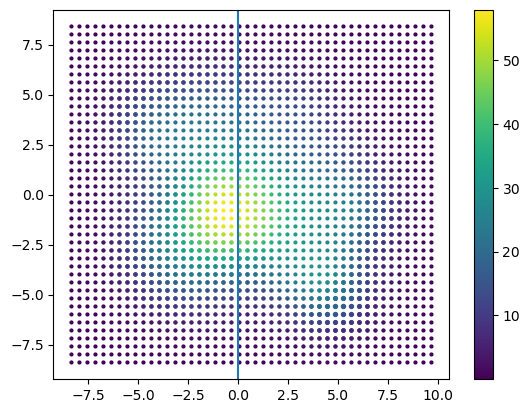

In [811]:
grd_real, my_data2_final, nx4, ny4 = interpolate_ij_xy_2d(my_grid, my_data_t, nx, ny, compute_error=True)

plt.scatter(grd_real.reshape([nx4 * ny4, 2])[:, 0], 
            grd_real.reshape([nx4 * ny4, 2])[:, 1], 
            c=my_data.flatten(), cmap='viridis', 
            # s=4.,
            s=np.abs(my_data.flatten() - my_data2_final.flatten()) * 5, 
            vmin=np.amin(my_data), vmax=np.amax(my_data)
           )

plt.scatter(my_grid.reshape([nx * ny, 2])[:, 0], 
            my_grid.reshape([nx * ny, 2])[:, 1], 
            c=my_data.flatten(), cmap='viridis', s=4.,
            vmin=np.amin(my_data), vmax=np.amax(my_data)
           )

plt.scatter(grd_real.reshape([nx4 * ny4, 2])[:, 0], 
            grd_real.reshape([nx4 * ny4, 2])[:, 1], 
            c=my_data2_final.flatten(), cmap='viridis',  # my_data_im_back
            s=1., 
            vmin=np.amin(my_data), vmax=np.amax(my_data)
           )
plt.colorbar()
plt.axvline(0., c='tab:blue')

# plt.scatter(crds[:, 0], crds[:, 1], c='tab:orange', s=6.)
plt.gca().set_aspect('equal')


### 2D example with rotation

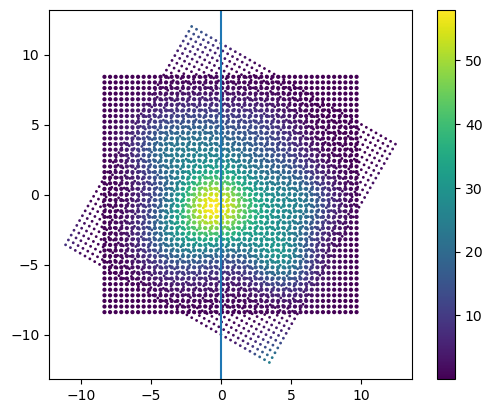

In [812]:
theta_ = np.pi - 60. *  np.pi / 180.  # x and y are swapped
tr = np.array([[np.cos(theta_), -np.sin(theta_)],
               [np.sin(theta_),  np.cos(theta_)]])
grd_real, my_data2_final, nx4, ny4 = interpolate_ij_xy_2d(my_grid, my_data_t, nx, ny,
                                                          r=tr)

plt.scatter(my_grid.reshape([nx * ny, 2])[:, 0], 
            my_grid.reshape([nx * ny, 2])[:, 1], 
            c=my_data.flatten(), cmap='viridis', s=4.,
            vmin=np.amin(my_data), vmax=np.amax(my_data)
           )

plt.scatter(grd_real.reshape([nx4 * ny4, 2])[:, 0], 
            grd_real.reshape([nx4 * ny4, 2])[:, 1], 
            c=my_data2_final.flatten(), cmap='viridis',  # my_data_im_back
            s=1., 
            vmin=np.amin(my_data), vmax=np.amax(my_data)
           )
plt.colorbar()
plt.axvline(0., c='tab:blue')

# plt.scatter(crds[:, 0], crds[:, 1], c='tab:orange', s=6.)
plt.gca().set_aspect('equal')


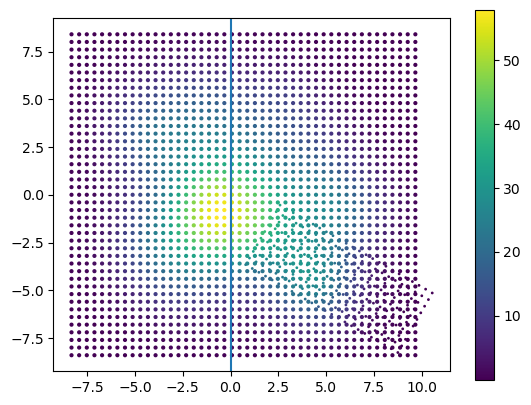

In [816]:
theta_ = np.pi - 60. *  np.pi / 180.  # x and y are swapped
tr = np.array([[np.cos(theta_), -np.sin(theta_)],
               [np.sin(theta_),  np.cos(theta_)]])
grd_real, my_data2_final, nx4, ny4 = interpolate_ij_xy_2d(my_grid, my_data_t, nx, ny,
                                                          r=tr,
                                                          tv=[10, 35], nx_patch=10, ny_patch=24)

plt.scatter(my_grid.reshape([nx * ny, 2])[:, 0], 
            my_grid.reshape([nx * ny, 2])[:, 1], 
            c=my_data.flatten(), cmap='viridis', s=4.,
            vmin=np.amin(my_data), vmax=np.amax(my_data)
           )

plt.scatter(grd_real.reshape([nx4 * ny4, 2])[:, 0], 
            grd_real.reshape([nx4 * ny4, 2])[:, 1], 
            c=my_data2_final.flatten(), cmap='viridis',  # my_data_im_back
            s=1., 
            vmin=np.amin(my_data), vmax=np.amax(my_data)
           )
plt.colorbar()
plt.axvline(0., c='tab:blue')

# plt.scatter(crds[:, 0], crds[:, 1], c='tab:orange', s=6.)
plt.gca().set_aspect('equal')


In [194]:
# verify we have the same grid cell dimension
np.linalg.norm(grd_real[0][0] - grd_real[0][1]), np.linalg.norm(grd_real[10][0] - grd_real[10][1]), np.linalg.norm(grd_real[0][10] - grd_real[0][11])

(0.3999998500819566, 0.3999998500819566, 0.39999980878665414)

### 3D example with rotation

In [855]:
# our grid in ij
my_grid = np.array(np.meshgrid(np.arange(-2., 1.1, 1.), np.arange(-1., 1.1, 1.), np.arange(-2., 2.1, 1.), indexing='ij')).transpose([1, 2, 3, 0])
# voxel size
vs = 1.
nx, ny, nz = my_grid.shape[0], my_grid.shape[1], my_grid.shape[2]
nxyz = np.array([nx, ny, nz])
# our data in ij
my_data = np.array([[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9], [10, 11, 12, 13, 14]],
                    [[15, 16, 17, 18, 19], [20, 21, 22, 23, 24], [25, 26, 27, 28, 29]],
                    [[30, 31, 32, 33, 34], [35, 36, 37, 38, 39], [40, 41, 42, 43, 44]],
                    [[45, 46, 47, 48, 49], [50, 51, 52, 53, 54], [55, 56, 57, 58, 59]]])
my_data_t = torch.tensor(my_data, dtype=torch.float32)
print(nxyz, my_data.shape)

[4 3 5] (4, 3, 5)


In [856]:
my_grid_flat = my_grid.reshape(-1, 3)
data=[go.Scatter3d(
            x=my_grid_flat[:, 0], y=my_grid_flat[:, 1], z=my_grid_flat[:, 2],
            mode='markers',
            marker={'color': my_data.flatten(),
                    'colorscale': 'turbo',
                    'size': 5., 'opacity': 0.8},
            name='orig'
        )]
fig = go.Figure(data=data)
fig.update_layout(
    scene = dict(
        xaxis = dict( range=[-3,3],), yaxis = dict( range=[-3,3],), zaxis = dict( range=[-3,3],)
    ),
    width=700, margin=dict(r=10, l=10, b=10, t=10)
)
fig.update_layout(scene_aspectmode='cube')
fig.show()

What we want from rotation in ijk:

In [857]:
theta_x_ = 0. *  np.pi / 180.  # swapped with real z (aka k), should be negative
theta_y_ = 0. *  np.pi / 180.  # should be negative for CC
theta_z_ = 60. *  np.pi / 180.  # swapped with real x (aka i)
tr = Rotation.from_rotvec([theta_x_, theta_y_, theta_z_]).as_matrix()
my_grid_rot = (tr @ (my_grid_flat - np.mean(my_grid_flat, 0)).T).T + np.mean(my_grid_flat, 0)

data=[go.Scatter3d(
            x=my_grid_flat[:, 0], y=my_grid_flat[:, 1], z=my_grid_flat[:, 2],
            mode='markers',
            marker={'color': my_data.flatten(),
                    'colorscale': 'turbo',
                    'size': 10.,
                    'opacity': 0.7, 'cmin': np.amin(my_data), 'cmax': np.amax(my_data)},
            name='orig'
        ),
      go.Scatter3d(
            x=my_grid_rot[:, 0], y=my_grid_rot[:, 1], z=my_grid_rot[:, 2],
            mode='markers',
            marker={'color': my_data.flatten(),
                    'colorscale': 'turbo',
                    'size': 5.,
                    'opacity': 0.8, 'cmin': np.amin(my_data), 'cmax': np.amax(my_data)},
            name='interpolation'
        )
     ]
fig = go.Figure(data=data)
fig.update_layout(
    scene = dict(
        xaxis = dict( range=[-3,3],), yaxis = dict( range=[-3,3],),  zaxis = dict( range=[-3,3],)
    ),
    width=700, margin=dict(r=10, l=10, b=10, t=10)
)
fig.update_layout(scene_aspectmode='cube')
fig.show()

In [849]:
def interpolate_ijk_xyz_3d(my_grid, my_data_t, 
                           nx, ny, nz,
                           compute_error=False, 
                           r=np.array([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]]),
                           tv=None, nx_patch=None, ny_patch=None, nz_patch=None):
    origin = np.amin(my_grid.reshape(-1, 3), axis=(0))    
    t = torch.tensor([
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]])
    # patch center in number of voxels from the corner; zyx instead of ijk
    tc1 = torch.tensor([np.ceil(nz - 1.)/2., np.ceil(ny - 1.)/2., np.ceil(nx - 1.)/2.]) if tv is None else torch.tensor([tv[2], tv[1], tv[0]])
    nx0 = (nz-1)/2
    ny0 = (ny-1)/2
    nz0 = (nx-1)/2
    nxyz0 = np.array([nx0, ny0, nz0], dtype=float)
    nxyz0_sp = np.array([nx0 if nz > 2 else 0, ny0 if ny > 2 else 0, nz0 if nx > 2 else 0], dtype=float)
    # patch size in number of voxels; yx instead of ij
    nx4, ny4, nz4 = nz if nz_patch is None else nz_patch, ny if ny_patch is None else ny_patch, nx if nx_patch is None else nx_patch         
    nxyz4 = np.array([nx4, ny4, nz4])
    sz_ = [1, 1, nx4, ny4, nz4]  # patch size in number of voxels; yx instead of ij
    sz = torch.Size(sz_)
    sz_t = torch.Size([sz_[0], sz_[1], sz_[4], sz_[3], sz_[2]])
    
    w = nx4
    h = ny4
    d = nz4
    
    t[0,0] = r[0][0]
    t[0,1] = r[0][1]*h/w 
    t[0,2] = r[0][2]*d/w
    t[1,0] = r[1][0]*w/h
    t[1,1] = r[1][1]
    t[1,2] = r[1][2]*d/h
    t[2,0] = r[2][0]*w/d
    t[2,1] = r[2][1]*h/d
    t[2,2] = r[2][2]
    
    grd = torch.nn.functional.affine_grid(t.unsqueeze(0), sz_t).permute(0, 3, 2, 1, 4)
    grd_real_im = ((grd * torch.tensor(sz_[2:]) * 0.5 + tc1) * vs) + origin[::-1]
    grd_relative = (grd_real_im - (origin[::-1] + nxyz0 * vs)) / (nxyz0 * vs)
    my_data2 = torch.nn.functional.grid_sample(
        my_data_t.unsqueeze(0).unsqueeze(0), 
        grd_relative.to(dtype=torch.float32), mode='bilinear', padding_mode='border')
    my_data2_final = my_data2[0][0].numpy().transpose(2, 1, 0)
    grd_real = np.flip(grd_real_im[0].numpy().transpose(2, 1, 0, 3), 3)
    if compute_error:
        print('mae', np.mean(np.abs(my_data_t.flatten().numpy() - my_data2_final.flatten())))
        print('mean', np.mean(np.abs(my_data_t.flatten().numpy())))
    return grd_real, my_data2_final, nx4, ny4, nz4

With rotation:

In [858]:
theta_x_ = -0. *  np.pi / 180.  # swapped with real z (aka k), negative for CC
theta_y_ = -0. *  np.pi / 180.  # negative for CC
theta_z_ = -0. *  np.pi / 180. # swapped with real x (aka i), negative for CC

tr = Rotation.from_rotvec([theta_x_, theta_y_, theta_z_]).as_matrix()
grd_real, my_data2_final, nx4, ny4, nz4 = interpolate_ijk_xyz_3d(my_grid, my_data_t, nx, ny, nz, r=tr, compute_error=True)

data=[go.Scatter3d(
            x=my_grid_flat[:, 0], y=my_grid_flat[:, 1], z=my_grid_flat[:, 2],
            mode='markers',
            marker={'color': my_data.flatten(),
                    'colorscale': 'turbo',
                    'size': 10.,
                    'opacity': 0.7, 'cmin': np.amin(my_data), 'cmax': np.amax(my_data)},
            name='orig'
        ),
      go.Scatter3d(
            x=grd_real.reshape(-1, 3)[:, 0], y=grd_real.reshape(-1, 3)[:, 1], z=grd_real.reshape(-1, 3)[:, 2],
            mode='markers',
            marker={'color': my_data2_final.flatten(),
                    'colorscale': 'turbo',
                    'size': 5.,
                    'opacity': 0.8, 'cmin': np.amin(my_data), 'cmax': np.amax(my_data)},
            name='interpolation'
        )
     ]
fig = go.Figure(data=data)
fig.update_layout(
    scene = dict(
        xaxis = dict( range=[-3,3],),
        yaxis = dict( range=[-3,3],),
        zaxis = dict( range=[-3,3],)
    ),
    width=700,
    margin=dict(r=10, l=10, b=10, t=10)
)
fig.update_layout(scene_aspectmode='cube')
fig.show()

np.linalg.norm(my_grid[0][0][0] - my_grid[0][0][1]), np.linalg.norm(my_grid[0][2][0] - my_grid[0][1][0]),\
np.linalg.norm(grd_real[0][0][0] - grd_real[0][0][1]), np.linalg.norm(grd_real[0][2][0] - grd_real[0][1][0]), np.linalg.norm(grd_real[2][2][0] - grd_real[1][2][0])

mae 1.2999994
mean 29.5


(1.0, 1.0, 1.0, 1.0, 0.9999999403953552)

### 3D example with more points and rotation

In [830]:
crds = np.vstack([np.random.uniform(-5, 5, (100, 3)),
                  np.random.uniform(-6, 6, (100, 3))]
                )
for i in range(5):
    loc = np.random.choice(range(len(crds)))
    crds = np.append(crds, 
                  np.random.normal(loc=crds[loc], scale=[1., 1., 1.], size=(20, 3)), axis=0)

In [831]:
crd_min = np.min(crds, axis=0)
crd_max = np.max(crds, axis=0)
crd_com = np.mean(crds, axis=0)
crd_padding = np.array([2.5, 2.5, 2.5])

vs = 0.4
my_grid = np.array(np.meshgrid(np.arange((crd_min - crd_padding)[0], (crd_max + crd_padding)[0], vs),
                               np.arange((crd_min - crd_padding)[1], (crd_max + crd_padding)[1], vs), 
                               np.arange((crd_min - crd_padding)[2], (crd_max + crd_padding)[2], vs), indexing='ij')).transpose([1, 2, 3, 0])
nx, ny, nz, _ = my_grid.shape
nxyz = np.array([nx, ny, nz])
my_data = np.exp(
    -((my_grid.reshape([nx, ny, nz, 1, my_grid.shape[3]]) - crds.reshape([1, 1, crds.shape[0], crds.shape[1]])) ** 2).sum(4)/4.).sum(3)

my_data_t = torch.tensor(my_data, dtype=torch.float32)
my_grid_t = torch.tensor(my_grid, dtype=torch.float32)
print(my_data_t.shape)

torch.Size([43, 44, 45])


In [835]:
# explicit rotation
theta_x_ = -0. *  np.pi / 180.  # swapped with real z (aka k), negative for CC
theta_y_ = -0. *  np.pi / 180.  # negative for CC
theta_z_ = -0. *  np.pi / 180. # swapped with real x (aka i), negative for CC
tr = Rotation.from_rotvec([theta_x_, theta_y_, theta_z_]).as_matrix()

# Random rotation
tr = Rotation.from_rotvec(-1. * get_random_rot().as_rotvec()).as_matrix()

grd_real, my_data2_final, nx4, ny4, nz4 = interpolate_ijk_xyz_3d(my_grid, my_data_t, nx, ny, nz, r=tr, 
                                                                 compute_error=True if np.all(tr == np.eye(3)) else False)
my_grid_flat = my_grid.reshape(-1, 3)
my_sele = my_data.flatten() > 3 * np.std(my_data.flatten())
my_sele2 = my_data2_final.flatten() > 3 * np.std(my_data.flatten())
data=[go.Scatter3d(
            x=my_grid_flat[my_sele, 0], y=my_grid_flat[my_sele, 1], z=my_grid_flat[my_sele, 2],
            mode='markers',
            marker={'color': my_data.flatten()[my_sele],
                    'colorscale': 'viridis',
                    'size': 2.,
                    'opacity': 1., 'cmin': np.amin(my_data), 'cmax': np.amax(my_data)},
            name='orig'
        ),
      go.Scatter3d(
            x=grd_real.reshape(-1, 3)[my_sele2, 0], y=grd_real.reshape(-1, 3)[my_sele2, 1], z=grd_real.reshape(-1, 3)[my_sele2, 2],
            mode='markers',
            marker={'color': my_data2_final.flatten()[my_sele2],
                    'colorscale': 'viridis',
                    'size': 2.,
                    'opacity': 0.8, 'cmin': np.amin(my_data), 'cmax': np.amax(my_data)},
            name='interpolation'
        )
     ]
fig = go.Figure(data=data)
fig.update_layout(
    width=700,
    margin=dict(r=10, l=10, b=10, t=10)
)
fig.update_layout(scene_aspectmode='cube')
fig.show()

np.linalg.norm(my_grid[0][0][0] - my_grid[0][0][1]), np.linalg.norm(my_grid[0][2][0] - my_grid[0][1][0]),\
np.linalg.norm(grd_real[0][0][0] - grd_real[0][0][1]), np.linalg.norm(grd_real[0][2][0] - grd_real[0][1][0]), np.linalg.norm(grd_real[2][2][0] - grd_real[1][2][0])

(0.40000000000000036,
 0.40000000000000036,
 0.40000064730290746,
 0.3999996997604066,
 0.40000117503923543)

In [852]:
# explicit rotation
theta_x_ = -0. *  np.pi / 180.  # swapped with real z (aka k), negative for CC
theta_y_ = -0. *  np.pi / 180.  # negative for CC
theta_z_ = -0. *  np.pi / 180. # swapped with real x (aka i), negative for CC
tr = Rotation.from_rotvec([theta_x_, theta_y_, theta_z_]).as_matrix()

# Random rotation
tr = Rotation.from_rotvec(-1. * get_random_rot().as_rotvec()).as_matrix()

grd_real, my_data2_final, nx4, ny4, nz4 = interpolate_ijk_xyz_3d(my_grid, my_data_t, nx, ny, nz, r=tr,
                                                                 compute_error=True if np.all(tr == np.eye(3)) else False,
                                                                 tv=[20, 25, 20], nx_patch=10, ny_patch=7, nz_patch=8)
my_grid_flat = my_grid.reshape(-1, 3)
my_sele = my_data.flatten() > 2.5 * np.std(my_data.flatten())
my_sele2 = my_data2_final.flatten() > 2.5 * np.std(my_data.flatten())
data=[go.Scatter3d(
            x=my_grid_flat[my_sele, 0], y=my_grid_flat[my_sele, 1], z=my_grid_flat[my_sele, 2],
            mode='markers',
            marker={'color': my_data.flatten()[my_sele],
                    'colorscale': 'viridis',
                    'size': 1.,
                    'opacity': 1., 'cmin': np.amin(my_data), 'cmax': np.amax(my_data)},
            name='orig'
        ),
      go.Scatter3d(
            x=grd_real.reshape(-1, 3)[my_sele2, 0], y=grd_real.reshape(-1, 3)[my_sele2, 1], z=grd_real.reshape(-1, 3)[my_sele2, 2],
            mode='markers',
            marker={'color': my_data2_final.flatten()[my_sele2],
                    'colorscale': 'viridis',
                    'size': 3.,
                    'opacity': 0.8, 'cmin': np.amin(my_data), 'cmax': np.amax(my_data)},
            name='interpolation'
        )
     ]
fig = go.Figure(data=data)
fig.update_layout(
    width=700,
    margin=dict(r=10, l=10, b=10, t=10)
)
fig.update_layout(scene_aspectmode='cube')
fig.show()

np.linalg.norm(my_grid[0][0][0] - my_grid[0][0][1]), np.linalg.norm(my_grid[0][2][0] - my_grid[0][1][0]),\
np.linalg.norm(grd_real[0][0][0] - grd_real[0][0][1]), np.linalg.norm(grd_real[0][2][0] - grd_real[0][1][0]), np.linalg.norm(grd_real[2][2][0] - grd_real[1][2][0])

(0.40000000000000036,
 0.40000000000000036,
 0.3999999246117952,
 0.40000001460175527,
 0.3999995469771242)